In [8]:
import originpro as op
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget
from numpy.fft import fft, fftshift

In [29]:
#filename ='010421CWUP.026.txt'
path = r'D:\random\THz-TDS\MAY21\transmission'
file = '100521_015.x'
originfilename = 'Polariser_test5'

#wafer1_THz_DIR07_LR_2
#wafer2_HR01

file_start = 0
file_end = 36
#ref_file = 18

delaystart = 9800 
delayend = 10800
intpoints = 2048

X = np.arange(0,361,10)

n_file = file_end-file_start+1

In [30]:
def findchar(s, ch):
    return [i for i, ltr in enumerate(s) if ltr == ch]

def filename_generator(file_start,nfile,fname,path):
    findex = findchar(fname, "x")
    prefilename = fname[:findex[0]]
    #postfilename = fname[findex[1]+2:]
    filename=[]
    for i in range(nfile):
        i=i+file_start
        temp_name = prefilename  + f'%i'%i
#        if i<10:
#            temp_name = prefilename  + f'00%i'%i + postfilename
#        elif i>=100:
#            temp_name = prefilename  + f'%i'%i + postfilename
#        else:
#            temp_name = prefilename  + f'0%i'%i + postfilename'''
        filename.append(path + '\\' + temp_name)
        #print(temp_name)
    return filename

def readfile(filename):
    import pandas as pd
    import numpy as np
    
    df = pd.read_csv(filename,skiprows=13,sep='\s+').iloc[:-1,:5]
    df=pd.DataFrame(np.array(df, dtype=float))
    index=["Distance (um)", "Delay (ps)", "Signal (V)", "Phase (deg)", "Rcos (theta)"]
    df=df.set_axis(index, axis=1, inplace=False).reset_index(drop=True)
    return df

def plot_amplitude(fft_freq, fft_ampsample, xmin, xmax, ymin, ymax, i):
    #plt.close()
    #plt.close()
    
    #plt.plot(fft_freq, fft_ampref, label='Reference',markersize=5)
    plt.plot(fft_freq, fft_ampsample, label='Sample_'+str(i),markersize=5)
    plt.yscale('log')
    plt.xlim(xmin,xmax)   #0 to 3THz
    plt.ylim(ymin,ymax)
    plt.grid(which = 'major',color='black', linestyle='-', linewidth=0.5, alpha = 0.4)
    plt.grid(which = 'minor',color='lightgray', linestyle='--', linewidth=1, alpha = 0.4)
    plt.xlabel('Frequency (THz)')
    plt.ylabel('Amplitude (a.u.)')
    plt.title('FFT Amplitude')
    plt.legend(loc='upper right')
    #plt.show()
    
def time2freq(filenames,i):
    #This function reads time data, performs interpolation and converts it to frequency amplitude and phase
    timedata        = readfile(filenames)
    int_timedata    = np.interp(int_delay,timedata.to_numpy()[:,1],timedata.to_numpy()[:,4]).reshape(intpoints)
    fft_amp         = abs(fftshift(fft(int_timedata)))[int(intpoints/2):]                   #Amplitude Axis
    fft_phase       = np.unwrap(np.angle((fftshift(fft(int_timedata)))[int(intpoints/2):])) #Phase axis
    plot_amplitude(fft_freq, fft_amp, 0, 3, 1e-3, 10, i)
    
    return int_timedata, fft_amp, fft_phase

def origincommentgenerator():
    intdelaystr = []
    ampstr = []
    phasestr = []
    transstr = []
    for i in range(n_file):
        intdelaystr.append('Intdelay_'+str(i+file_start))
        ampstr.append('Amp_'+str(i+file_start))
        phasestr.append('Phase_'+str(i+file_start))
        transstr.append('Trans_'+str(i+file_start))
    return intdelaystr, ampstr, phasestr, transstr

In [31]:
filenames = filename_generator(file_start, n_file,file,path)
#Interpolated Delay Axis
delaytotal = (delayend-delaystart)/149.89623                     #delaytotal in terahertz
delaydelta = (delaytotal)/(intpoints-1)                          #delaydelta in terahertz
int_delay  = np.arange(0,intpoints)*delaydelta+delaystart/149.89623

maxdata  = []
maxindex = []

for i in range(n_file):
    timedata        = readfile(filenames[i])
    int_timedata    = np.interp(int_delay,timedata.to_numpy()[:,1],timedata.to_numpy()[:,4]).reshape(intpoints)
    maxdata.append(np.amax(int_timedata))
    maxindex.append(np.argmax(int_timedata))

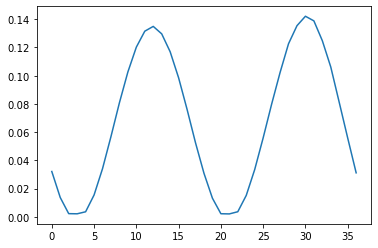

In [32]:
plt.plot(maxdata)

In [33]:
data  = op.new_sheet(lname='Data')
index = op.new_sheet(lname='Index')

data.from_list(0, X, 'Angle',  units = 'deg' ,axis='X')
data.from_list(1, maxdata, 'Data' , units = 'mV',axis='Y')
index.from_list(0, X, 'Angle',  units = 'deg' ,axis='X')
index.from_list(1, maxindex, 'Index' ,axis='Y')

op.save(os.path.normpath(os.path.normpath(path)) + '\\' + originfilename + '.opju')
op.exit()